In [1]:
library('RODBC')
library('quantmod')
library('PerformanceAnalytics')
library('lubridate')
source("/usr/common/config.R")
lcon <- odbcDriverConnect(sprintf("Driver={SQL Server};Server=%s;Database=%s;Uid=%s;Pwd=%s;", ldbserver, ldbname, ldbuser, ldbpassword), case = "nochange", believeNRows = TRUE)

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [2]:
startDate<-as.Date('2007-04-01')
endDate<-as.Date('2017-03-31')

startYear<-year(startDate)
endYear<-year(endDate)
numYears<-endYear-startYear+1
weights<-seq(from=99, to=1, length.out=numYears)

wXts<-xts(weights[1]/100.0, as.Date(sprintf("%d-01-01", startYear)))
for(i in 2:numYears){
    wXts<-rbind(wXts, xts(weights[i]/100.0, as.Date(sprintf("%d-01-01", startYear+i-1))))
}

names(wXts)<-c("EQUITY")
wXts$BOND<-1.0-wXts[,1]
wXts$GOLD<-0.0
#wXts$EQUITY<-wXts$EQUITY*0.9

In [3]:
nifty<-sqlQuery(lcon, sprintf("select TIME_STAMP, PX_CLOSE FROM BHAV_INDEX WHERE INDEX_NAME='NIFTY MID100 FREE' AND TIME_STAMP >='%s' AND TIME_STAMP <= '%s'", startDate, endDate))
nXts<-xts(nifty[,-1], as.Date(nifty[,1]))
nRets<-annualReturn(nXts)

ndf<-data.frame(nRets)
rownames(ndf)<-lapply(rownames(ndf), FUN=function(x) sprintf("%d-%d-25", year(as.Date(x)), month(as.Date(x))))
nRets<-xts(ndf[,1], as.Date(rownames(ndf)))
    
bonds<-sqlQuery(lcon, sprintf("select TIME_STAMP, TRI FROM INDEX_CCIL_TENOR WHERE INDEX_NAME='10_15' AND TIME_STAMP >='%s' AND TIME_STAMP <= '%s'", startDate, endDate))
bXts<-xts(bonds[,-1], as.Date(bonds[,1]))
bRets<-annualReturn(bXts)
    
ndf<-data.frame(bRets)
rownames(ndf)<-lapply(rownames(ndf), FUN=function(x) sprintf("%d-%d-25", year(as.Date(x)), month(as.Date(x))))
bRets<-xts(ndf[,1], as.Date(rownames(ndf)))
    
gold<-sqlQuery(lcon, sprintf("select TIME_STAMP, PX_CLOSE FROM PX_HISTORY WHERE SYMBOL='GOLDBEES' AND TIME_STAMP >='%s' AND TIME_STAMP <= '%s'", startDate, endDate))
gXts<-xts(gold[,-1], as.Date(gold[,1]))
gRets<-annualReturn(gXts)
    
ndf<-data.frame(gRets)
rownames(ndf)<-lapply(rownames(ndf), FUN=function(x) sprintf("%d-%d-25", year(as.Date(x)), month(as.Date(x))))
gRets<-xts(ndf[,1], as.Date(rownames(ndf)))

constXts<-merge(nRets, bRets, gRets)
names(constXts)<-c('EQUITY', 'BOND', 'GOLD')

In [4]:
print(constXts)
print(wXts)

                EQUITY         BOND        GOLD
2007-12-25  0.96320007  0.074948970  0.12418238
2008-12-25 -0.59394990  0.285051816  0.24457939
2009-12-25  0.98972053 -0.085244436  0.24937780
2010-12-25  0.19163707  0.066565802  0.21694852
2011-12-25 -0.30995687  0.047780290  0.29869645
2012-12-25  0.39157538  0.116407105  0.11219232
2013-12-25 -0.05100469  0.008729062 -0.06393166
2014-12-25  0.55908590  0.183779974 -0.09322907
2015-12-25  0.06459470  0.078262917 -0.07503602
2016-12-25  0.07126755  0.158763707  0.12519469
2017-03-25  0.19828658 -0.010007650  0.01881385
           EQUITY  BOND GOLD
2007-01-01  0.990 0.010    0
2008-01-01  0.892 0.108    0
2009-01-01  0.794 0.206    0
2010-01-01  0.696 0.304    0
2011-01-01  0.598 0.402    0
2012-01-01  0.500 0.500    0
2013-01-01  0.402 0.598    0
2014-01-01  0.304 0.696    0
2015-01-01  0.206 0.794    0
2016-01-01  0.108 0.892    0
2017-01-01  0.010 0.990    0


In [5]:
wtdRets <- Return.portfolio(constXts, weights=wXts, verbose=T)

print(sprintf("Combined portfolio - Cumulative: %.2f%%; Annualized: %.2f%%; Max drawdown: %.2f%%", 100.0*Return.cumulative(wtdRets$returns), 100.0*Return.annualized(wtdRets$returns), 100*data.frame(table.Drawdowns(wtdRets$returns, top=1))$Depth))
print(sprintf("Gold only portfolio - Cumulative: %.2f%%; Annualized: %.2f%%; Max drawdown: %.2f%%", 100.0*Return.cumulative(constXts$BOND), 100.0*Return.annualized(constXts$GOLD), 100*data.frame(table.Drawdowns(constXts$GOLD, top=1))$Depth))
print(sprintf("Equity only portfolio - Cumulative: %.2f%%; Annualized: %.2f%%; Max drawdown: %.2f%%", 100.0*Return.cumulative(constXts$EQUITY), 100.0*Return.annualized(constXts$EQUITY), 100*data.frame(table.Drawdowns(constXts$EQUITY, top=1))$Depth))
print(sprintf("Bond only portfolio - Cumulative: %.2f%%; Annualized: %.2f%%; Max drawdown: %.2f%%", 100.0*Return.cumulative(constXts$BOND), 100.0*Return.annualized(constXts$BOND), 100*data.frame(table.Drawdowns(constXts$BOND, top=1))$Depth))

[1] "Combined portfolio - Cumulative: 227.29%; Annualized: 11.38%; Max drawdown: -49.90%"
[1] "Gold only portfolio - Cumulative: 132.86%; Annualized: 9.69%; Max drawdown: -21.49%"
[1] "Equity only portfolio - Cumulative: 266.98%; Annualized: 12.55%; Max drawdown: -59.39%"
[1] "Bond only portfolio - Cumulative: 132.86%; Annualized: 7.99%; Max drawdown: -8.52%"


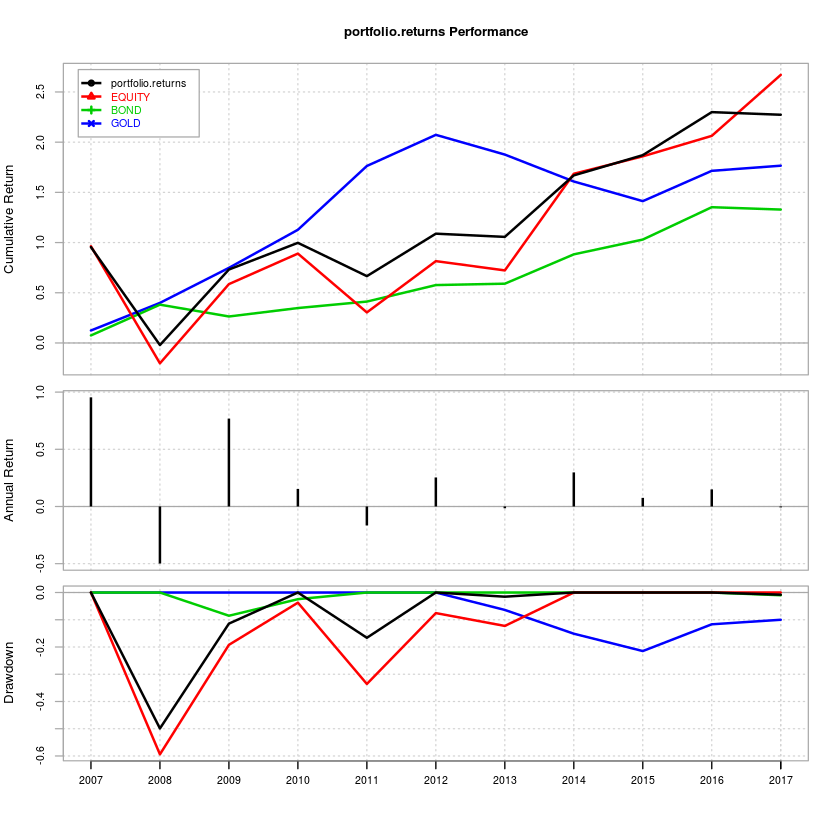

In [6]:
charts.PerformanceSummary(merge(wtdRets$returns, constXts$EQUITY, constXts$BOND, constXts$GOLD))

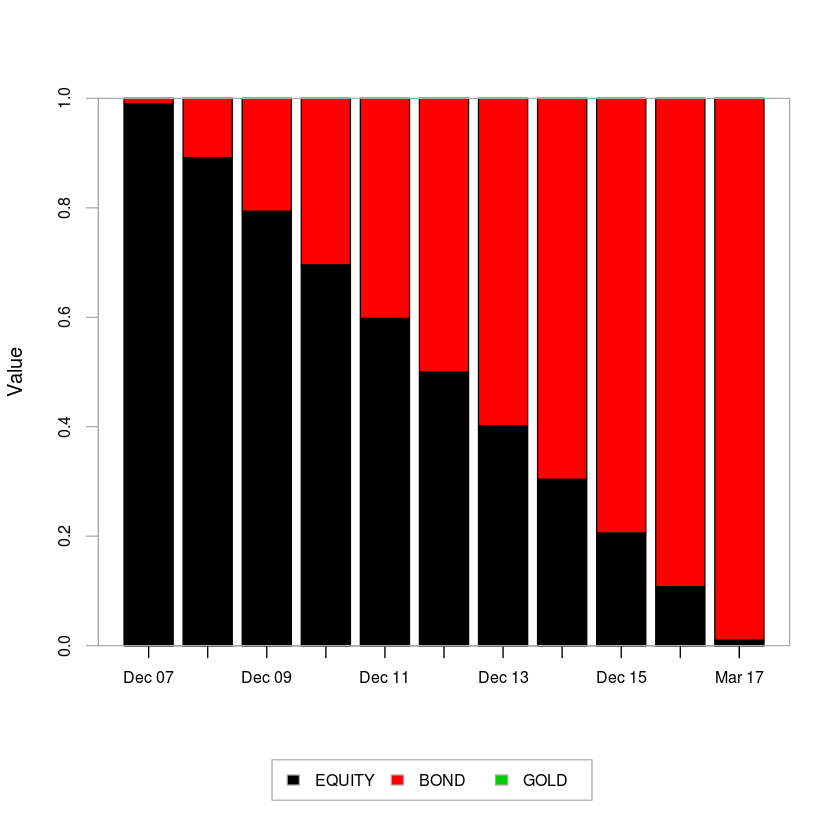

In [7]:
chart.StackedBar(wtdRets$BOP.Weight)

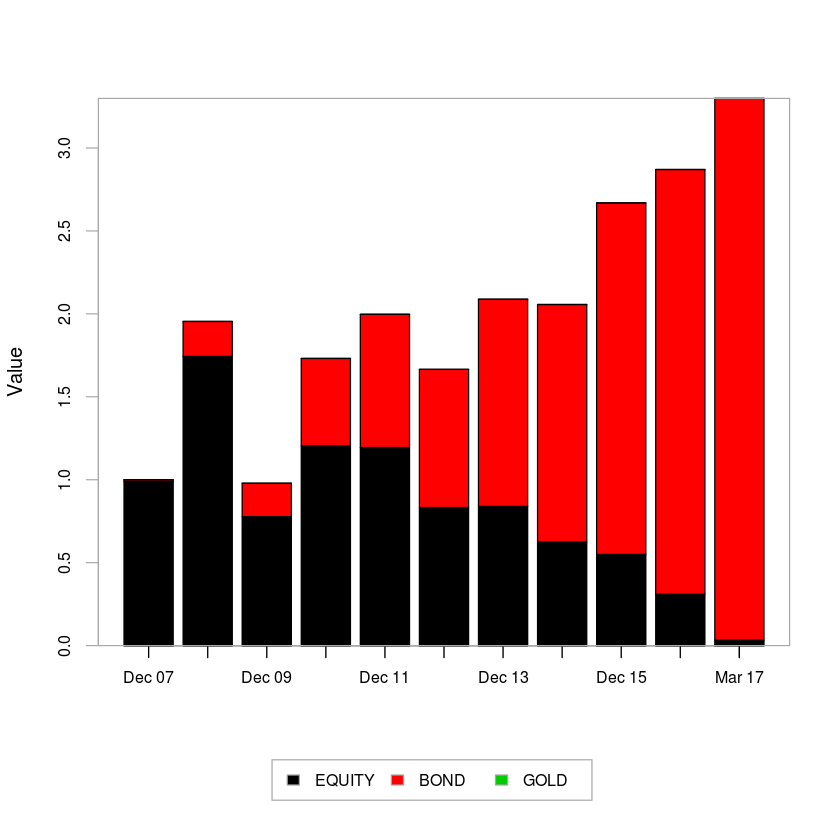

In [8]:
chart.StackedBar(wtdRets$BOP.Value)